<h1>Classification Toy Model</h1>

The goal of this notebook is to get familiar with unsupervised classification, using small and silly subsets of the bikeshare data.

<h2>Feature Extraction</h2>

We begin with a toy model of bikeshare rides, relying on some very simple (and perhaps silly) features for classification. To begin with, we will use the trip's day of the week, hour of day, and duration.

In [1]:
import pandas as pd 

# Load dataset
df = pd.read_csv('data/trip.csv')
date_format = '%m/%d/%Y %H:%M'
trip_starts = pd.to_datetime(df.start_date, format = date_format)
trip_ends = pd.to_datetime(df.end_date, format = date_format)

# Feature 1: Trip day of week, with Monday = 0 and Sunday = 6
day = trip_starts.dt.dayofweek

# Feature 2: Trip hour of day (0 to 23)
hour = trip_starts.dt.hour

# Feature 3: Trip duration (seconds)
duration = df.duration

# Consolidate features into DataFrame
features = pd.concat([day, hour, duration], axis = 1)
features.columns = ['day', 'hour', 'duration']

<h2>Feature Cleaning</h2>

The next step is to clean the data. Day of week and hour don't require much cleaning by way of removing outliers, so we will simply enforce that their values are what we expect.

In [2]:
valid_day = features.day.isin(range(7))
valid_hour = features.hour.isin(range(24))
features = features[valid_day & valid_hour]

Durations require a bit more cleaning. To begin with, we'll remove observations with are more than 3 standard deviations above the mean. We'll then plot a histogram to get a sense of the duration distribution.

Mean: 1107.9498461846172 seconds
Standard deviation: 22255.437020085345 seconds


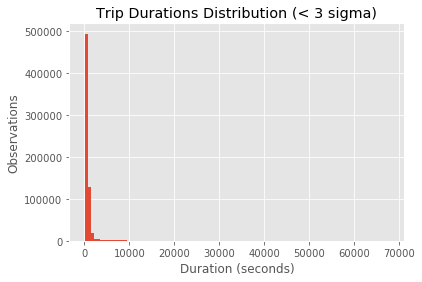

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.clf()

# Find outliers
mu = features.duration.mean()
sigma = features.duration.std()
outlier_idx = (features.duration - mu) > 3 * sigma

# Plot histogram without outliers
features[~outlier_idx].hist(column = 'duration', bins = 100)
plt.xlabel('Duration (seconds)')
plt.ylabel('Observations')
plt.title('Trip Durations Distribution (< 3 sigma)')
print('Mean:', mu, 'seconds')
print('Standard deviation:', sigma, 'seconds')
plt.show()

Even removing 3-sigma outliers, the distribution looks horrible: there are lots of really long trips. Using standard deviations might not be the best way to clean the data.

As a next attempt, we can choose to exclude the top 5% of data:

95% quantile: 1881.0 seconds


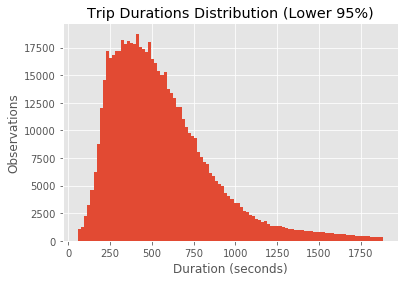

In [4]:
# Remove top 5% outliers
q = features.duration.quantile(0.95)
print('95% quantile:', q, 'seconds')
features = features[features.duration <= q]

# Show histogram of remaining data
plt.clf()
features.hist(column = 'duration', bins = 100)
plt.xlabel('Duration (seconds)')
plt.ylabel('Observations')
plt.title('Trip Durations Distribution (Lower 95%)')
plt.show()

Much better. Now we have what looks like a skewed Gaussian or a beta distribution in trip duration.

<h2>Feature Analysis</h2>

Now we'll examine our feature vectors to anticipate the types of clusters that we will need. We have three dimensions of data, so we'll plot them in two-dimensional slices at first.

<h3>Trip Duration vs. Day of Week</h3>

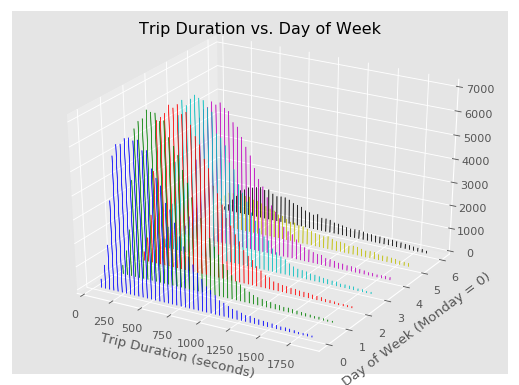

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

plt.clf()
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111, projection='3d')
nbins = 50

for d, c in zip(range(7), ['b', 'g', 'r', 'c', 'm', 'y', 'k']):
    hist, bins = np.histogram(features.duration[features.day == d], bins = nbins)
    bin_midpoints = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_midpoints, hist, zs = d, zdir = 'y', color = c, ec = c, alpha = 0.8)
    
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Day of Week (Monday = 0)')
plt.title('Trip Duration vs. Day of Week')
plt.show()

This plot is quite interesting, as there is a clear difference in ride behavior between week days and weekend days. Most obviously, there are fewer rides on weekends. But rides also tend to be longer. The peak of the ride duration distribution doesn't change much, but the tail becomes "lighter," as some riders go on longer rides.

<h3>Trip Duration vs. Hour of Day</h3>

There are lots of hours in the day, so we'll divide the day into 8 3-hour blocks, starting from midnight (hour zero). These blocks will be late night (12am-3am), early morning (3am-6am), morning (6am-9am), late morning (9am-12pm), early afternoon (12pm-3pm), late afternoon (3pm-6pm), evening (6pm-9pm), and night (9pm-12pm).

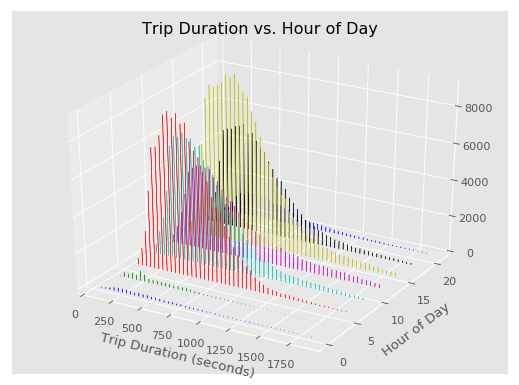

In [6]:
plt.clf()
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111, projection='3d')
nbins = 50

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(8):
    hmin = 3 * i
    hmax = hmin + 2
    c = colors[i % len(colors)]
    hist, bins = np.histogram(features.duration[(features.hour >= hmin) & (features.hour <= hmax)], bins = nbins)
    bin_midpoints = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_midpoints, hist, zs = hmin, zdir = 'y', color = c, ec = c, alpha = 0.8)
    
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Hour of Day')
plt.title('Trip Duration vs. Hour of Day')
plt.show()

Again, some obvious features: rides tend to occur during daylight hours. There are almost no rides during late night and early morning, and relatively few rides during the evening. Rides tend to peak during the morning and late afternoon, supporting the idea that rides are dominated by commuters. Duration distributions are relatively consistent within the dominant times of day.

<h3>Hour of Day vs. Day of Week</h3>

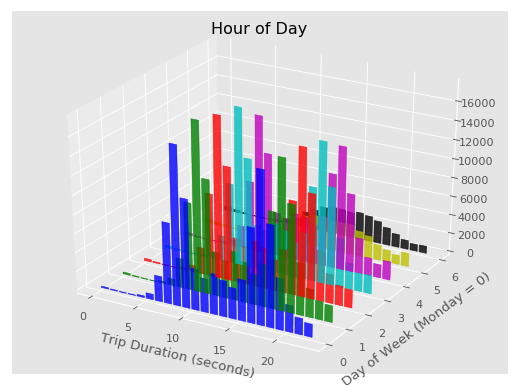

In [7]:
plt.clf()
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for d, c in zip(range(7), ['b', 'g', 'r', 'c', 'm', 'y', 'k']):
    hist, bins = np.histogram(features.hour[features.day == d], bins = range(24))
    bin_midpoints = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_midpoints, hist, zs = d, zdir = 'y', color = c, ec = c, alpha = 0.8)
    
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Day of Week (Monday = 0)')
plt.title('Hour of Day')
plt.show()

Some more evidence supporting a commuter cluster: during week days, rides typically occur from 6-10am and 3-6pm (roughly), corresponding to peoples' commutes to and from work. On the weekends, distributions are more rounded, spread out over daylight hours.

<h3>Discussion</h3>

Based on day of week and hour of day, we can visually identify two broad clusters of riders: weekday commuters, and weekend leisure riders. We could further partition these clusters based on ride duration. If we apply a clustering algorithm, will it agree with the intuitive clustering of rides?

<h2>Gaussian Mixture Clustering</h2>

We'll start with the simplest clustering approach, using a Gaussian mixture model. The model learns a fixed number of multivariate normal distributions in feature space, assigning likelihoods of membership for each observed ride.

To start, let's see if we can tease out the three obvious categories of riders: weekend leisure riders, morning weekday commuters, and afternoon weekday commuters:

In [8]:
from sklearn import mixture

N_CLUSTERS = 3
model = mixture.GaussianMixture(N_CLUSTERS).fit(features)

print(model.means_)

[[    2.22678416    12.98119581   351.36473596]
 [    2.30428829    13.01920097   677.78360191]
 [    3.06628892    13.82486558  1196.50287576]]


The simplest GMM fit completely misses the mark. The average day / hour of each cluster is just the average day / hour across the entire data set, which is useless. The mixture model primarily utilizes the ride duration variable to cluster riders, giving us three categories: 5 minute riders, 10 minute riders, and 20 minute riders.

In retrospect, this should be obvious. There simply aren't many weekend riders, so it doesn't make sense for the EM algorithm to waste a cluster separating these riders. But classification by ride duration is not especially interesting. We'll try removing the duration feature, and cluster over weekday and hour alone:

[[  3.39561054  12.91419234]
 [  2.06669451   8.25551796]
 [  2.19828708  17.4447294 ]]


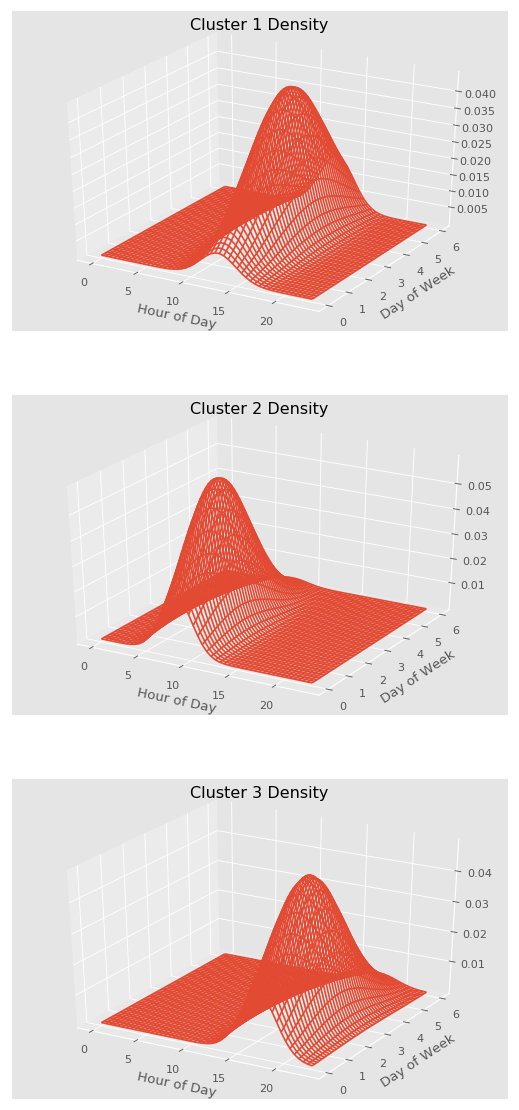

In [9]:
import scipy.stats

model = mixture.GaussianMixture(N_CLUSTERS).fit(features[['day', 'hour']])
print(model.means_)

# Prepare surface plot of GMM density
plt.clf()
fig = plt.figure(figsize=(8, 18), dpi=80)
days = np.linspace(0, 6, 50)
hours = np.linspace(0, 23, 50)
xx, yy = np.meshgrid(days, hours)
X = np.column_stack((xx.flatten(), yy.flatten()))
for cluster in range(N_CLUSTERS):
    mu = model.means_[cluster, :]
    sigma = model.covariances_[cluster, :, :]
    Z = scipy.stats.multivariate_normal(mean = mu, cov = sigma).pdf(X)
    zz = Z.reshape(50, 50)
    ax = fig.add_subplot(310 + cluster + 1, projection='3d')
    ax.plot_wireframe(yy, xx, zz)
    plt.ylabel('Day of Week')
    plt.xlabel('Hour of Day')
    plt.title('Cluster ' + str(cluster + 1) + ' Density')
plt.show()
    

Slight improvement. Cluster 1 is focused on morning commuters, with a slight weekday bias. Cluster 2 is focused on evening commuters, with an even slighter weekday bias. And Cluster 3 captures the group of midday riders, incorporating weekday and weekend riders in a nearly equal balance. While these clusters hint at the 3 groups we wanted to identify (morning commuters, evening commuters, and weekend riders), the groups are not very well distinguished. We will have to try something else.

<h2>Hierarchial Clustering</h2>

GMM clustering has difficulty distinguishing weekend from weekday commuters, probably because the weekend rider share is very small. But it is very clear from the feature analysis above that weekend riders and weekday riders have very different behavior, and should be separated as such. We will exercise a bit of force, using a hierarchial clustering scheme now, where we manually separate weekday from weekend riders as the first partition. Then we can discard the day of the week.

In [10]:
cols = ['hour', 'duration']
feature_dict = dict()
feature_dict['weekend'] = features[features.day.isin([5, 6])][cols]
feature_dict['weekday'] = features[features.day.isin(range(5))][cols]

Now we can discard the day feature, and try GMM clustering again, within the weekday cluster.

In [11]:
model = dict()
model['weekday'] = mixture.GaussianMixture(2).fit(feature_dict['weekday'])

Did it work? Let's find out. Cluster 1 is boring at the moment, since it's just the set of all weekend rides. Clusters 2 and 3 are the sub-clusters of the weekday riders:

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


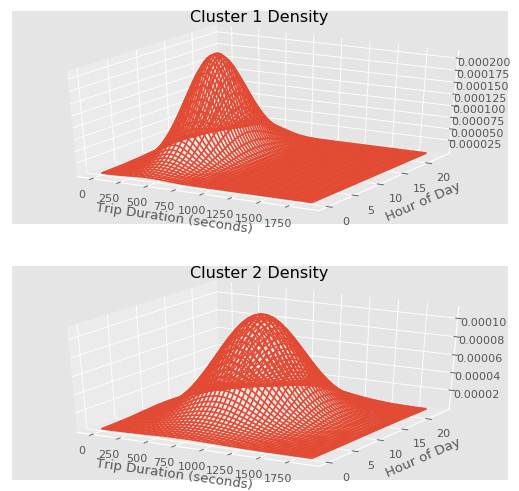

In [12]:
plt.clf()
fig = plt.figure(figsize=(8, 12), dpi=80)

print(model['weekday'])

hours = np.linspace(0, 23, 50)
durations = np.linspace(0, feature_dict['weekday'].duration.max())
xx, yy = np.meshgrid(hours, durations)
X = np.column_stack((xx.flatten(), yy.flatten()))
for cluster in range(2):
    mu = model['weekday'].means_[cluster, :]
    sigma = model['weekday'].covariances_[cluster, :, :]
    Z = scipy.stats.multivariate_normal(mean = mu, cov = sigma).pdf(X)
    zz = Z.reshape(50, 50)
    ax = fig.add_subplot(310 + cluster + 1, projection='3d')
    ax.plot_wireframe(yy, xx, zz)
    plt.xlabel('Trip Duration (seconds)')
    plt.ylabel('Hour of Day')
    plt.title('Cluster ' + str(cluster + 1) + ' Density')
plt.show()